# Instalação e Importação de Bibliotecas

Este bloco de código realiza duas tarefas principais:

Instalação de bibliotecas: Ele garante que as bibliotecas Python necessárias para executar o restante do notebook estejam instaladas no seu ambiente.
Importação de módulos e funções: Ele carrega módulos e funções específicas dessas bibliotecas para que possam ser utilizados posteriormente no código.

In [ ]:
# --- 0. Instalação e Importação das Bibliotecas ---
# Descomente a linha abaixo se as bibliotecas não estiverem instaladas
!pip install xgboost imbalanced-learn pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier # NOVO: Importando o XGBoost

# Modelagem e Pré-processamento
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc)
from sklearn.pipeline import Pipeline # ALTERADO: Usaremos o Pipeline padrão do Scikit-learn



# Configurações e Carregamento dos Dados
Esta seção do código executa duas tarefas principais: definir opções de exibição para DataFrames do pandas e carregar seus dados de um arquivo CSV.

In [ ]:
# --- 1. Configurações e Carregamento dos Dados ---
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

try:
    df = pd.read_csv('dados_tratados_combinados.csv')
    print("Arquivo 'dados_tratados_combinados.csv' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'dados_tratados_combinados.csv' não encontrado.")
    exit()

# Definição da Variável Alvo
Esta seção do código se concentra na preparação da variável-alvo para o seu modelo de aprendizado de máquina. A variável-alvo é o que você está tentando prever. Neste caso, está relacionada à satisfação profissional.

In [ ]:

# --- 2. Definição da Variável Alvo: Satisfação Profissional ---
target_col_original = 'você_está_satisfeito_na_sua_empresa_atual?'
target_col_final = 'target_satisfeito'
df.dropna(subset=[target_col_original], inplace=True)
df[target_col_final] = df[target_col_original].astype(int)
print("\nDistribuição da variável alvo (Satisfação):")
print(df[target_col_final].value_counts(normalize=True))



In [ ]:
# --- 3. Engenharia e Seleção de Features (sem alterações) ---
categorical_features = [
    'nivel', 'faixa_salarial', 'setor', 'numero_de_funcionarios',
    'atualmente_qual_a_sua_forma_de_trabalho?'
]
experience_col = 'quanto_tempo_de_experiência_na_área_de_dados_você_tem?'
exp_map = {
    'Não tenho experiência na área de dados': 0, 'Menos de 1 ano': 0.5, 'de 1 a 2 anos': 1.5,
    'de 3 a 4 anos': 3.5, 'de 5 a 6 anos': 5.5, 'de 7 a 10 anos': 8.5, 'Mais de 10 anos': 12
}
df['experiencia_anos'] = df[experience_col].map(exp_map).fillna(0)
motivos_features = [
    'falta_de_oportunidade_de_crescimento_no_emprego_atual',
    'salário_atual_não_corresponde_ao_mercado',
    'não_tenho_uma_boa_relação_com_meu_líder_gestor',
    'gostaria_de_receber_mais_benefícios',
    'o_clima_de_trabalho_ambiente_não_é_bom',
    'falta_de_maturidade_analítica_na_empresa'
]
numeric_features = ['experiencia_anos'] + motivos_features
for col in numeric_features:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
final_cat_features = [col for col in categorical_features if col in df.columns]
final_num_features = [col for col in numeric_features if col in df.columns]
final_features_list = final_cat_features + final_num_features
print("\nFeatures selecionadas para o modelo:", final_features_list)



*Este trecho de código faz parte de uma seção maior que lida com o pré-processamento dos dados e a configuração de um pipeline para o modelo XGBoost. Especificamente, a linha que você destacou está relacionada ao tratamento do desbalanceamento nas classes da variável alvo (satisfação profissional).*

In [ ]:



# --- 4. Pré-processamento e Pipeline com XGBoost ---
for col in final_cat_features:
    df[col] = df[col].fillna('Não Informado')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), final_cat_features),
        ('num', StandardScaler(), final_num_features)
    ],
    remainder='drop'
)
X = df[final_features_list]
y = df[target_col_final]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# NOVO: Cálculo do scale_pos_weight para lidar com o desbalanceamento
# Fórmula: (contagem da classe majoritária / contagem da classe minoritária)
# Neste caso, Satisfeito (1) é majoritária, Insatisfeito (0) é minoritária.
# O peso é aplicado na classe positiva (1), mas o ideal é pesar a minoritária.
# A documentação do XGBoost recomenda: count(negative_class) / count(positive_class)
count_neg = y_train.value_counts()[0]
count_pos = y_train.value_counts()[1]
scale_pos_weight_value = count_neg / count_pos
print(f"\nValor do scale_pos_weight calculado: {scale_pos_weight_value:.2f}")

# ALTERADO: Pipeline agora usa XGBoost e não precisa mais do SMOTE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic', # Objetivo de classificação binária
        eval_metric='logloss',       # Métrica de avaliação interna
        use_label_encoder=False,     # Configuração recomendada para versões recentes
        scale_pos_weight=scale_pos_weight_value # Parâmetro para balanceamento
    ))
])



# Treinamento e Otimização do Modelo XGBoost
Este bloco de código foca no treinamento e otimização do modelo de classificação XGBoost que foi configurado no bloco anterior. A otimização é feita através de uma técnica chamada busca aleatória de hiperparâmetros.

In [ ]:
# --- 5. Treinamento e Otimização do Modelo XGBoost ---
print("\nIniciando treinamento com XGBoost e busca de hiperparâmetros...")

# NOVO: Parâmetros específicos para o XGBoost
params = {
    'classifier__n_estimators': [100, 200, 400],
    'classifier__learning_rate': [0.02, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7, 10],         # Profundidade máxima da árvore
    'classifier__subsample': [0.7, 0.8, 1.0],       # Fração de amostras por árvore
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],# Fração de features por árvore
    'classifier__gamma': [0, 0.1, 0.25],            # Mínima redução de perda para criar um novo galho
    'classifier__reg_alpha': [0, 0.1, 0.5],         # Regularização L1
    'classifier__reg_lambda': [1, 1.5, 2]           # Regularização L2
}

search = RandomizedSearchCV(
    pipeline, params, n_iter=50, cv=5, # Aumentei n_iter para explorar mais combinações
    scoring='f1_macro', verbose=1, n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)
best_model = search.best_estimator_


**Este código faz parte da seção de avaliação do modelo. Especificamente, ele gera e exibe uma matriz de confusão para o conjunto de teste .**

Arquivo 'dados_tratados_combinados.csv' carregado com sucesso.

Distribuição da variável alvo (Satisfação):
target_satisfeito
1    0.719546
0    0.280454
Name: proportion, dtype: float64

Features selecionadas para o modelo: ['nivel', 'faixa_salarial', 'setor', 'numero_de_funcionarios', 'atualmente_qual_a_sua_forma_de_trabalho?', 'experiencia_anos', 'falta_de_oportunidade_de_crescimento_no_emprego_atual', 'salário_atual_não_corresponde_ao_mercado', 'não_tenho_uma_boa_relação_com_meu_líder_gestor', 'gostaria_de_receber_mais_benefícios', 'o_clima_de_trabalho_ambiente_não_é_bom', 'falta_de_maturidade_analítica_na_empresa']

Valor do scale_pos_weight calculado: 0.39

Iniciando treinamento com XGBoost e busca de hiperparâmetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



AVALIAÇÃO COMPARATIVA: TREINO VS. TESTE (XGBOOST)

Melhores parâmetros encontrados:
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.25, 'classifier__colsample_bytree': 0.7}

--- Relatório de Classificação (TREINO) ---
AUC-ROC no Treino: 0.988
              precision    recall  f1-score   support

Insatisfeito       1.00      0.91      0.95       933
  Satisfeito       0.97      1.00      0.98      2394

    accuracy                           0.97      3327
   macro avg       0.98      0.96      0.97      3327
weighted avg       0.98      0.97      0.97      3327


--- Relatório de Classificação (TESTE) ---
AUC-ROC no Teste: 0.961
              precision    recall  f1-score   support

Insatisfeito       1.00      0.87      0.93       400
  Satisfeito       0.95      1.00      0.98      1026

    accuracy                       

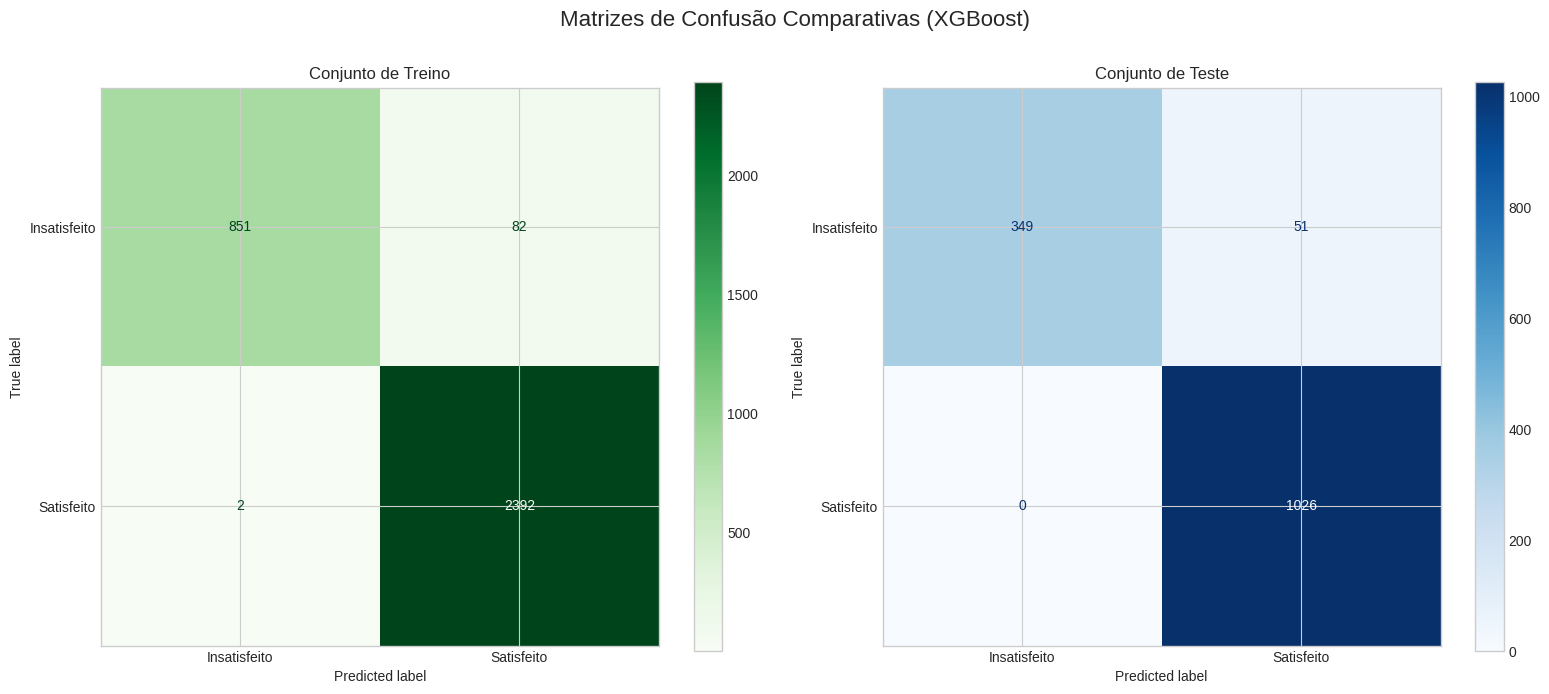


GERANDO CURVA DE APRENDIZAGEM (XGBoost)


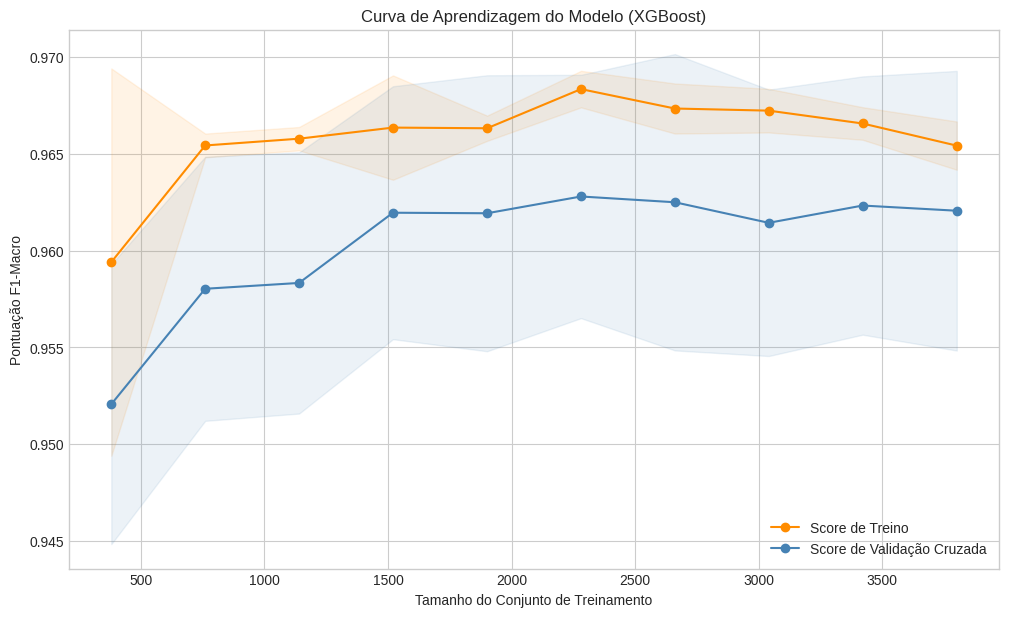


GERANDO CURVA ROC COMPARATIVA (XGBoost)


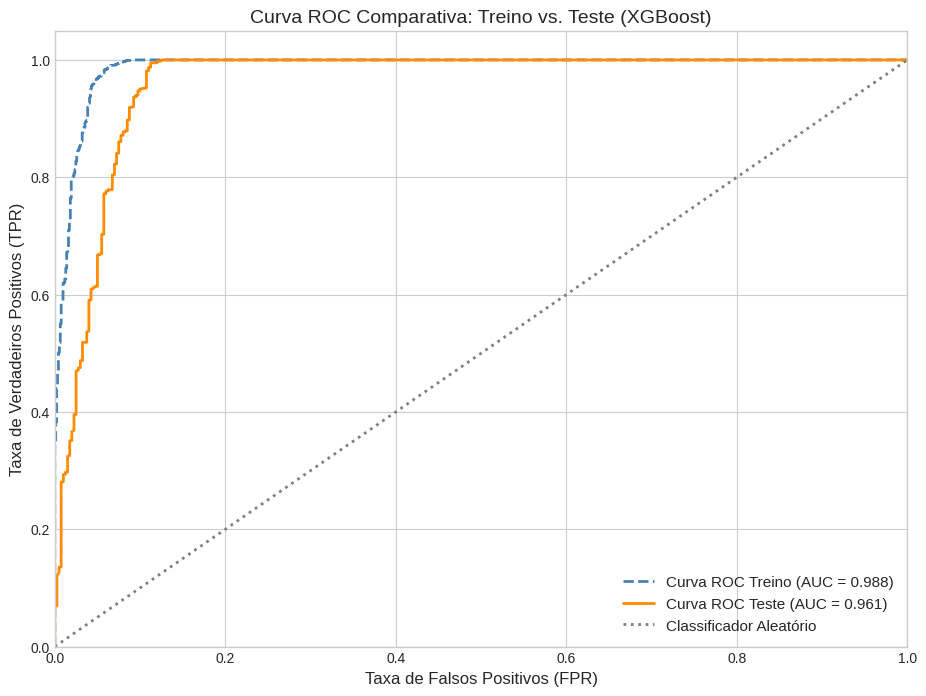


GERANDO GRÁFICO DE IMPORTÂNCIA DAS FEATURES (XGBoost)


<ipython-input-1-627262981>:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(12, 10)); sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature', palette='cividis')


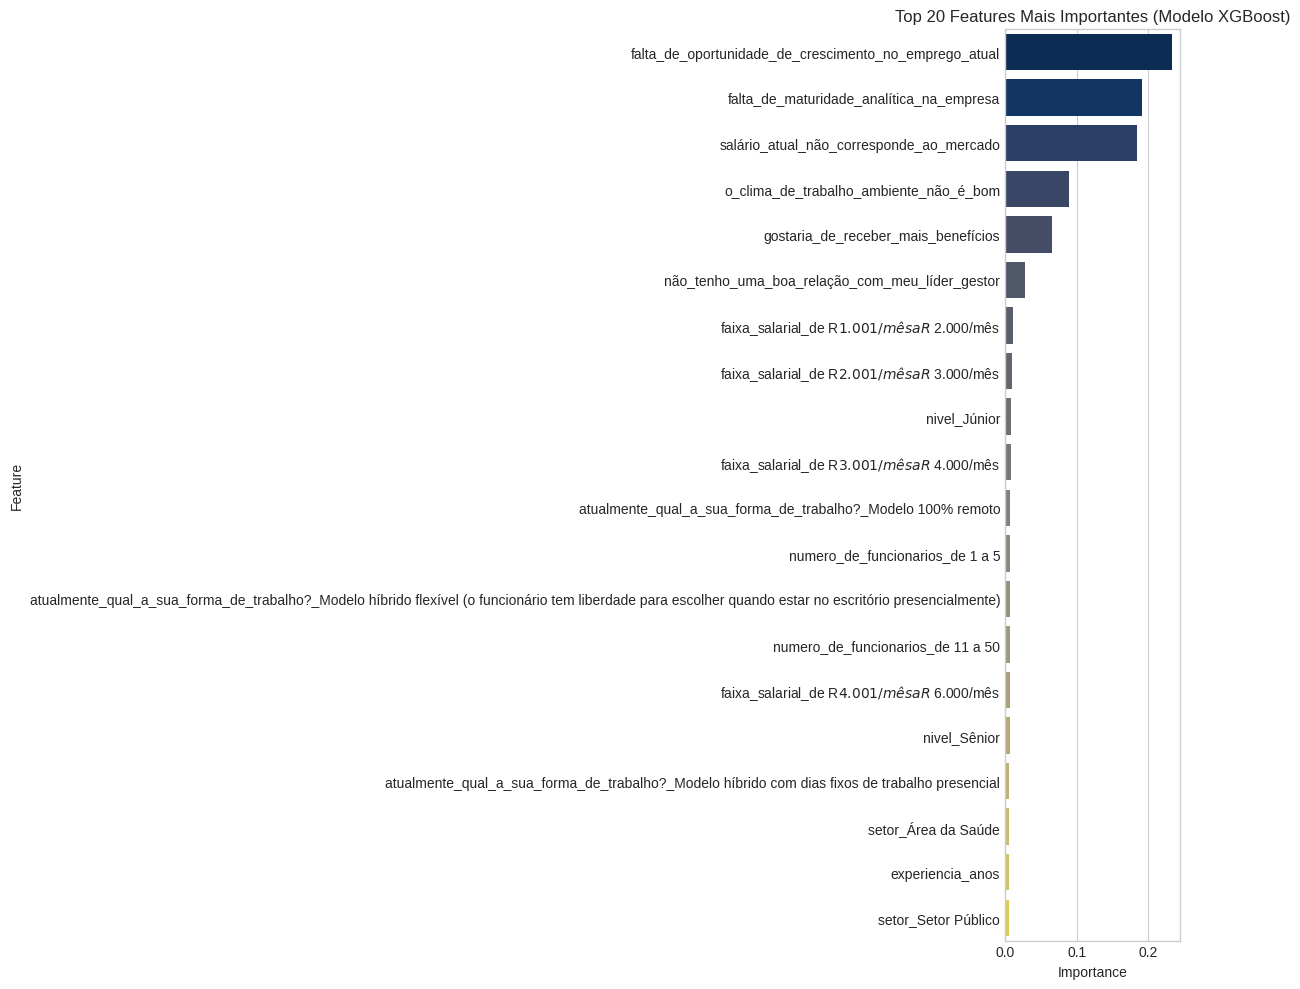

In [1]:



# --- 6. Avaliação e Visualização dos Resultados (O código abaixo permanece o mesmo) ---

# Predições para ambos os conjuntos
y_pred_train = best_model.predict(X_train)
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("AVALIAÇÃO COMPARATIVA: TREINO VS. TESTE (XGBOOST)")
print("="*60)
print("\nMelhores parâmetros encontrados:")
print(search.best_params_)

# Relatórios de Classificação
print("\n--- Relatório de Classificação (TREINO) ---")
print(f"AUC-ROC no Treino: {roc_auc_score(y_train, y_proba_train):.3f}")
print(classification_report(y_train, y_pred_train, target_names=['Insatisfeito', 'Satisfeito']))
print("\n--- Relatório de Classificação (TESTE) ---")
print(f"AUC-ROC no Teste: {roc_auc_score(y_test, y_proba_test):.3f}")
print(classification_report(y_test, y_pred_test, target_names=['Insatisfeito', 'Satisfeito']))

# Matrizes de Confusão Comparativas
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Matrizes de Confusão Comparativas (XGBoost)', fontsize=16)
ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train, cmap='Greens', ax=axes[0], display_labels=['Insatisfeito', 'Satisfeito'])
axes[0].set_title('Conjunto de Treino')
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues', ax=axes[1], display_labels=['Insatisfeito', 'Satisfeito'])
axes[1].set_title('Conjunto de Teste')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Curva de Aprendizagem
print("\n" + "="*60)
print("GERANDO CURVA DE APRENDIZAGEM (XGBoost)")
print("="*60)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model, X=X, y=y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)
train_scores_mean = np.mean(train_scores, axis=1); test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1); test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(12, 7)); plt.title("Curva de Aprendizagem do Modelo (XGBoost)"); plt.xlabel("Tamanho do Conjunto de Treinamento"); plt.ylabel("Pontuação F1-Macro")
plt.plot(train_sizes, train_scores_mean, 'o-', color="darkorange", label="Score de Treino")
plt.plot(train_sizes, test_scores_mean, 'o-', color="steelblue", label="Score de Validação Cruzada")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="steelblue")
plt.legend(loc="best"); plt.show()

# Curva ROC Comparativa
print("\n" + "="*60); print("GERANDO CURVA ROC COMPARATIVA (XGBoost)"); print("="*60)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test); roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train); roc_auc_train = auc(fpr_train, tpr_train)
plt.figure(figsize=(11, 8)); plt.title('Curva ROC Comparativa: Treino vs. Teste (XGBoost)', fontsize=14)
plt.plot(fpr_train, tpr_train, color='steelblue', lw=2, linestyle='--', label=f'Curva ROC Treino (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Curva ROC Teste (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle=':', label='Classificador Aleatório')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12); plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.legend(loc="lower right", fontsize=11); plt.show()

# Importância das Features
print("\n" + "="*60); print("GERANDO GRÁFICO DE IMPORTÂNCIA DAS FEATURES (XGBoost)"); print("="*60)
try:
    cat_features_out = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(final_cat_features)
    all_feature_names = np.concatenate([cat_features_out, final_num_features])
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 10)); sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature', palette='cividis')
    plt.title('Top 20 Features Mais Importantes (Modelo XGBoost)'); plt.tight_layout(); plt.show()
except Exception as e:
    print(f"\nNão foi possível gerar o gráfico de importância de features: {e}")